# Import

In [2]:
import pandas as pd
import numpy as np
import gensim

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam


In [4]:
filepath = "/Users/huiyee/Downloads/Study/Year3Sem2/FYP_project/Dataset_After_Preprocessing_GohHuiYee_TP066298/preprocessing2.csv"
new_df = pd.read_csv(filepath)

# Feature Extraction

In [5]:
# Function to remove inner spaces within tokens
def remove_inner_spaces(token_list):
    return ["".join(token.split()) for token in token_list]

# Apply the function to the 'port_stem' column
new_df['cleaned_tokens'] = new_df['port_stem'].apply(eval)  # Convert string representation of list to actual list
new_df['cleaned_tokens'] = new_df['cleaned_tokens'].apply(remove_inner_spaces)

# Convert lists of tokens to strings
new_df['joined_tokens'] = new_df['cleaned_tokens'].apply(lambda tokens: " ".join(tokens))

# Drop rows with NaN in 'joined_tokens'
new_df = new_df.dropna(subset=['joined_tokens'])

# Drop rows with empty 'joined_tokens' strings
new_df = new_df[new_df['joined_tokens'].str.strip() != '']


In [4]:
filepath = "/Users/huiyee/Downloads/Study/Year3Sem1/FYP/new_df.csv"
new_df = pd.read_csv(filepath)

## TF-IDF

In [5]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Apply the TF-IDF vectorizer to the joined token strings
tfidf_matrix = vectorizer.fit_transform(new_df['joined_tokens'])

# Verify the shape of the resulting TF-IDF matrix
print(tfidf_matrix.shape)

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_matrix, 
                                                                            new_df['class'], 
                                                                            test_size=0.2, 
                                                                            random_state=42)

(231993, 176343)


## Bag Of Words (BoW)

In [6]:
# Initialize the CountVectorizer (Bag of Words model)
count_vectorizer = CountVectorizer()

# Apply the CountVectorizer to the joined token strings
bow_matrix = count_vectorizer.fit_transform(new_df['joined_tokens'])

# Verify the shape of the resulting BoW matrix
print(bow_matrix.shape)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_matrix, 
                                                                    new_df['class'], 
                                                                    test_size=0.2, 
                                                                    random_state=42)

(231993, 176343)


## Word2Vec

In [7]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=new_df['cleaned_tokens'], vector_size=100, 
                          window=5, min_count=1, workers=4, sg=1)

# Function to average word vectors for each document
def document_vector(tokens, model):
    # Remove out-of-vocabulary words
    tokens = [token for token in tokens if token in model.wv.key_to_index]
    if len(tokens) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[tokens], axis=0)

# Apply the function to create document vectors
new_df['doc_vector'] = new_df['cleaned_tokens'].apply(lambda tokens: 
                                                      document_vector(tokens, 
                                                                      word2vec_model))

# Convert the document vectors to a matrix
X = np.vstack(new_df['doc_vector'].values)
X_train_vector, X_test_vector, y_train_vector, y_test_vector = train_test_split(X, 
                                                                                new_df['class'], 
                                                                                test_size=0.2, 
                                                                                random_state=42)

# Model Building

## Base Model 

In [8]:
# Function to train and evaluate models
def train_and_evaluate(X_train, X_test, y_train, y_test, model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Print the classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("="*60)

# Initialize classifiers
svm = SVC()
log_reg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

# List of models and their names
models = [(svm, "SVM"), (log_reg, "Logistic Regression"), (knn, "KNN"), (rf, "Random Forest"), 
          (dt, "Decision Tree")]

# Evaluate models with TF-IDF features
print("Evaluating models with TF-IDF features:")
for model, name in models:
    train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, model, name)

# Evaluate models with Bag of Words features
print("Evaluating models with Bag of Words features:")
for model, name in models:
    train_and_evaluate(X_train_bow, X_test_bow, y_train_bow, y_test_bow, model, name)

Evaluating models with TF-IDF features:
Classification Report for SVM:
              precision    recall  f1-score   support

  depression       0.95      0.93      0.94     23402
   teenagers       0.93      0.95      0.94     22997

    accuracy                           0.94     46399
   macro avg       0.94      0.94      0.94     46399
weighted avg       0.94      0.94      0.94     46399

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

  depression       0.94      0.91      0.92     23402
   teenagers       0.91      0.94      0.92     22997

    accuracy                           0.92     46399
   macro avg       0.92      0.92      0.92     46399
weighted avg       0.92      0.92      0.92     46399

Classification Report for KNN:
              precision    recall  f1-score   support

  depression       0.87      0.01      0.02     23402
   teenagers       0.50      1.00      0.66     22997

    accuracy                     

In [26]:
# Function to train and evaluate models
def train_and_evaluate(X_train, X_test, y_train, y_test, model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Print the classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("="*60)

# Initialize classifiers
svm = SVC()
log_reg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

# List of models and their names
models = [(svm, "SVM"), (log_reg, "Logistic Regression"), (knn, "KNN"), (rf, "Random Forest"), 
          (dt, "Decision Tree")]

# Evaluate models with Word2Vec features
print("Evaluating models with Word2Vec features:")
for model, name in models:
    train_and_evaluate(X_train_vector, X_test_vector, y_train_vector, y_test_vector, model, name)

Evaluating models with Word2Vec features:
Classification Report for SVM:
              precision    recall  f1-score   support

  depression       0.76      0.89      0.82     23402
   teenagers       0.87      0.71      0.78     22997

    accuracy                           0.80     46399
   macro avg       0.81      0.80      0.80     46399
weighted avg       0.81      0.80      0.80     46399

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

  depression       0.74      0.89      0.81     23402
   teenagers       0.86      0.68      0.76     22997

    accuracy                           0.79     46399
   macro avg       0.80      0.79      0.79     46399
weighted avg       0.80      0.79      0.79     46399

Classification Report for KNN:
              precision    recall  f1-score   support

  depression       0.74      0.89      0.81     23402
   teenagers       0.86      0.69      0.77     22997

    accuracy                   

## Depression Prediction

### Random Forest

In [23]:
#Best Parameters (Grid Search)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

# Perform the grid search
grid_search_rf.fit(X_train_tfidf, y_train_tfidf)

# Print the best parameters and the best score
print("Best Parameters:", grid_search_rf.best_params_)

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


### Decision Tree

In [17]:
#Best Parameters (Grid Search)
# Set up the parameter grid
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, n_jobs=-1, verbose=2)

# Perform the grid search
grid_search_dt.fit(X_train_bow, y_train_bow)

# Print the best parameters and the best score
print("Best Parameters:", grid_search_dt.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=10.7min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=10.8min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=11.0min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=11.6min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=11.6min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=11.8min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=11.8min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=11.8min
[C

### SVM

In [ ]:
#Best Parameters
# Define the parameter grid for the SVM
param_grid_svm = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

# Initialize the SVM classifier
svm = SVC()

# Initialize GridSearchCV with the SVM and the parameter grid
grid_search_svm = GridSearchCV(svm, param_grid_svm, refit=True, 
                               verbose=3, cv=5, n_jobs=-1,return_train_score=True)

# Fit the grid search to the training data
grid_search_svm.fit(X_train_tfidf, y_train_tfidf)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best score: {grid_search_svm.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 2/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.923, test=0.916) total time=206.5min
[CV 3/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.923, test=0.916) total time=207.1min
[CV 5/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.923, test=0.918) total time=207.3min
[CV 1/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.922, test=0.918) total time=207.2min
[CV 4/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.922, test=0.918) total time=207.7min
[CV 1/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.918, test=0.908) total time=241.6min
[CV 2/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.918, test=0.906) total time=253.0min
[CV 3/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.918, test=0.907) total time=253.3min
[CV 2/5] END C=0.1, gamma=0.1, kernel=linear;, score=(train=0.923, test=0.916) total time=137.8min
[CV 1/5] END C=0.1, gamma=0.1, kernel=linear;, score=(train=0.922, test=0

### LR

In [21]:
#Best Parameters (Grid Search)
# Set up the parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Regularization type
    'solver': ['liblinear', 'saga'] # Solvers that handle l1 penalty
}

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(estimator=log_reg, param_grid=param_grid_lr, cv=5, n_jobs=-1)

# Perform the grid search
grid_search_lr.fit(X_train_tfidf, y_train_tfidf)

# Print the best parameters and the best score
print("Best Parameters:", grid_search_lr.best_params_)
print("Best Cross-Validation Score:", grid_search_lr.best_score_)

/Users/huiyee/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huiyee/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huiyee/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huiyee/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huiyee/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huiyee/anaconda3/lib/python3.11/site-packages/sklearn

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.9302563654285418


### KNN

In [ ]:
#Best Parameters (Grid Search)
# Set up the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],       # Number of neighbors to consider
    'weights': ['uniform', 'distance'],   # Weight function used in prediction
    'metric': ['euclidean', 'cosine']     # Distance metric for the tree
}

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=2)

# Perform the grid search
grid_search_knn.fit(X_train_vector, y_train_vector)

# Print the best parameters and the best score
print("Best Parameters:", grid_search_knn.best_params_)
print("Best Cross-Validation Score:", grid_search_knn.best_score_)

# Get the best model
best_knn_classifier = grid_search_knn.best_estimator_

# Predict the labels for the test set using the best model
y_pred_vector_knn = best_knn_classifier.predict(X_test_vector)

# Evaluate the best model
print("Test Accuracy:", accuracy_score(y_test_vector, y_pred_vector_knn))
print("Classification Report:\n", classification_report(y_test_vector, y_pred_vector_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test_vector, y_pred_vector_knn))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time= 3.1min
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time= 3.1min
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time= 3.2min
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time= 3.2min
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time= 3.2min
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time= 3.2min
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time= 3.2min
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time= 3.2min
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time= 3.0min
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time= 3.0min
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time= 3.0min
[CV] END ...metric=euclidean, n_neighbors=5, we

NameError: name 'confusion_matrix' is not defined

## Sentiment Prediction

### Resampling

In [6]:
from sklearn.utils import shuffle

#Separate the majority and minority classes
new_df_majority = new_df[new_df['sentiment_label'] == 'Negative']
new_df_minor = new_df[new_df['sentiment_label'] == 'Neutral']
new_df_positive = new_df[new_df['sentiment_label'] == 'Positive']

#Downsample the majority class
new_df_major_downsampled = new_df_majority.sample(new_df_minor.shape[0], random_state=42)
new_df_positive_downsampled = new_df_positive.sample(new_df_minor.shape[0], random_state=42)

#Combine the downsampled majority class with the minority classes
new_df_downsampled = pd.concat([new_df_major_downsampled, new_df_minor, new_df_positive_downsampled])
new_df_downsampled = shuffle(new_df_downsampled, random_state=42)

#Separate the features and target
X_train_resampled = new_df_downsampled.drop('sentiment_label', axis=1)
y_train_resampled = new_df_downsampled['sentiment_label']
class_distribution_resampled = y_train_resampled.value_counts()
print("Class Distribution after Resampling:")
print(class_distribution_resampled)

#Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

#Apply the TF-IDF vectorizer to the joined token strings
tfidf_matrix_downsample = vectorizer.fit_transform(new_df_downsampled['joined_tokens'])

#Initialize the CountVectorizer (Bag of Words model)
count_vectorizer = CountVectorizer()

#Apply the CountVectorizer to the joined token strings
bow_matrix_downsample = count_vectorizer.fit_transform(new_df_downsampled['joined_tokens'])

Class Distribution after Resampling:
sentiment_label
Neutral     13122
Positive    13122
Negative    13122
Name: count, dtype: int64


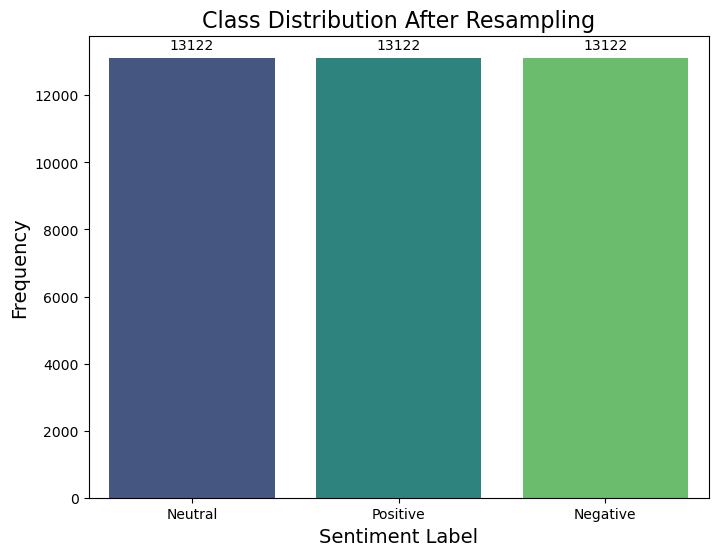

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart of class distribution after resampling
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_distribution_resampled.index, y=class_distribution_resampled.values, palette="viridis")

# Adding titles and labels
plt.title('Class Distribution After Resampling', fontsize=16)
plt.xlabel('Sentiment Label', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding the data labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# Display the plot
plt.show()


### TF-IDF & BoW

In [ ]:
#Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

#Apply the TF-IDF vectorizer to the joined token strings
tfidf_matrix_downsample = vectorizer.fit_transform(new_df_downsampled['joined_tokens'])

#Initialize the CountVectorizer (Bag of Words model)
count_vectorizer = CountVectorizer()

#Apply the CountVectorizer to the joined token strings
bow_matrix_downsample = count_vectorizer.fit_transform(new_df_downsampled['joined_tokens'])

#Perform TF-IDF & BoW for ['sentiment_label]
X_train_tfidf_sentiment_down, X_test_tfidf_sentiment_down, y_train_tfidf_sentiment_down, y_test_tfidf_sentiment_down = train_test_split(
    tfidf_matrix_downsample, new_df_downsampled['sentiment_label'], test_size=0.2, random_state=42)
print("TF-IDF Sentiment Split Shapes:", X_train_tfidf_sentiment_down.shape, X_test_tfidf_sentiment_down.shape, 
      y_train_tfidf_sentiment_down.shape, y_test_tfidf_sentiment_down.shape)

X_train_bow_sentiment_down, X_test_bow_sentiment_down, y_train_bow_sentiment_down, y_test_bow_sentiment_down = train_test_split(
    bow_matrix_downsample, new_df_downsampled['sentiment_label'], test_size=0.2, random_state=42)
print("BoW Sentiment Split Shapes:", X_train_bow_sentiment_down.shape, X_test_bow_sentiment_down.shape, 
      y_train_bow_sentiment_down.shape, y_test_bow_sentiment_down.shape) 

TF-IDF Sentiment Split Shapes: (31492, 50373) (7874, 50373) (31492,) (7874,)
BoW Sentiment Split Shapes: (31492, 50373) (7874, 50373) (31492,) (7874,)


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import ComplementNB

#Test Using TF-IDF & BoW (#Based Model (Using BoW more higher))
def train_evaluate_model(X_train, X_test, y_train, y_test):
    # Initialize the Multinomial Naive Bayes classifier
    model = ComplementNB()
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

# Evaluate model using TF-IDF for 'sentiment_label'
accuracy_tfidf_sentiment, report_tfidf_sentiment = train_evaluate_model(X_train_tfidf_sentiment_down, 
                                                                        X_test_tfidf_sentiment_down, 
                                                                        y_train_tfidf_sentiment_down, 
                                                                        y_test_tfidf_sentiment_down)
print("TF-IDF (Sentiment) - Accuracy:", accuracy_tfidf_sentiment)
print("TF-IDF (Sentiment) - Classification Report:\n", report_tfidf_sentiment)

# Evaluate model using BoW for 'sentiment_label'
accuracy_bow_sentiment, report_bow_sentiment = train_evaluate_model(X_train_bow_sentiment_down, 
                                                                    X_test_bow_sentiment_down, 
                                                                    y_train_bow_sentiment_down, 
                                                                    y_test_bow_sentiment_down)
print("BoW (Sentiment) - Accuracy:", accuracy_bow_sentiment)
print("BoW (Sentiment) - Classification Report:\n", report_bow_sentiment)

TF-IDF (Sentiment) - Accuracy: 0.6422402844805689
TF-IDF (Sentiment) - Classification Report:
               precision    recall  f1-score   support

    Negative       0.58      0.82      0.68      2620
     Neutral       0.76      0.69      0.72      2694
    Positive       0.61      0.41      0.49      2560

    accuracy                           0.64      7874
   macro avg       0.65      0.64      0.63      7874
weighted avg       0.65      0.64      0.63      7874

BoW (Sentiment) - Accuracy: 0.6446532893065786
BoW (Sentiment) - Classification Report:
               precision    recall  f1-score   support

    Negative       0.62      0.75      0.68      2620
     Neutral       0.71      0.70      0.70      2694
    Positive       0.60      0.48      0.53      2560

    accuracy                           0.64      7874
   macro avg       0.64      0.64      0.64      7874
weighted avg       0.64      0.64      0.64      7874



### Decision Tree

In [ ]:
#Test Using TF-IDF & BoW (Based Model (Using BoW)
#Function to train and evaluate a Decision Tree model
def train_evaluate_decision_tree(X_train, X_test, y_train, y_test):
    # Initialize the Decision Tree classifier
    model = DecisionTreeClassifier(random_state=42)
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Evaluate Decision Tree model using TF-IDF for 'sentiment_label'
accuracy_tfidf_sentiment, report_tfidf_sentiment = train_evaluate_decision_tree(
    X_train_tfidf_sentiment_down, X_test_tfidf_sentiment_down, y_train_tfidf_sentiment_down, y_test_tfidf_sentiment_down)
print("TF-IDF (Sentiment) - Decision Tree - Accuracy:", accuracy_tfidf_sentiment)
print("TF-IDF (Sentiment) - Decision Tree - Classification Report:\n", report_tfidf_sentiment)

accuracy_bow_sentiment, report_bow_sentiment = train_evaluate_decision_tree(
    X_train_bow_sentiment_down, X_test_bow_sentiment_down, y_train_bow_sentiment_down, y_test_bow_sentiment_down)
print("BoW (Sentiment) - Decision Tree - Accuracy:", accuracy_bow_sentiment)
print("BoW (Sentiment) - Decision Tree - Classification Report:\n", report_bow_sentiment)


TF-IDF (Sentiment) - Decision Tree - Accuracy: 0.7125984251968503
TF-IDF (Sentiment) - Decision Tree - Classification Report:
               precision    recall  f1-score   support

    Negative       0.63      0.61      0.62      2620
     Neutral       0.88      0.89      0.88      2694
    Positive       0.62      0.64      0.63      2560

    accuracy                           0.71      7874
   macro avg       0.71      0.71      0.71      7874
weighted avg       0.71      0.71      0.71      7874

BoW (Sentiment) - Decision Tree - Accuracy: 0.7247904495808991
BoW (Sentiment) - Decision Tree - Classification Report:
               precision    recall  f1-score   support

    Negative       0.65      0.63      0.64      2620
     Neutral       0.88      0.90      0.89      2694
    Positive       0.63      0.64      0.64      2560

    accuracy                           0.72      7874
   macro avg       0.72      0.72      0.72      7874
weighted avg       0.72      0.72      0.72  

### RNN

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# Assuming 'new_df' is your dataframe and 'joined_tokens' contains the text data
texts = new_df_downsampled['joined_tokens'].values
labels = new_df_downsampled['sentiment_label'].values

# Split the data into training and testing sets
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_ori)

X_train_seq = tokenizer.texts_to_sequences(X_train_ori)
X_test_seq = tokenizer.texts_to_sequences(X_test_ori)

# Pad the sequences to ensure uniform length
max_len = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encode labels into numerical format and convert to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_ori)
y_test_encoded = label_encoder.transform(y_test_ori)

num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes)

In [ ]:
#Base Model
# Define the RNN model
vocab_size = len(tokenizer.word_index) + 1

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=100))
model_rnn.add(LSTM(128))
model_rnn.add(Dense(num_classes, activation='softmax'))

model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the RNN model
model_rnn.fit(X_train_pad, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test_cat), verbose=1)

Epoch 1/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 4662s 5s/step - accuracy: 0.6690 - loss: 0.7185 - val_accuracy: 0.7955 - val_loss: 0.4964
Epoch 2/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 5317s 5s/step - accuracy: 0.8473 - loss: 0.3928 - val_accuracy: 0.8218 - val_loss: 0.4534
Epoch 3/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 5970s 6s/step - accuracy: 0.8932 - loss: 0.2958 - val_accuracy: 0.8092 - val_loss: 0.4845
Epoch 4/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 6432s 7s/step - accuracy: 0.9168 - loss: 0.2343 - val_accuracy: 0.8028 - val_loss: 0.5222
Epoch 5/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 6070s 6s/step - accuracy: 0.9396 - loss: 0.1721 - val_accuracy: 0.7958 - val_loss: 0.5997
Epoch 6/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 8877s 9s/step - accuracy: 0.9593 - loss: 0.1245 - val_accuracy: 0.7913 - val_loss: 0.6715
Epoch 7/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 7031s 7s/step - accuracy: 0.9681 - loss: 0.0983 - val_accuracy: 0.7827 - val_loss: 0.8019
Epoch 8/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 6944s 7s/step - accuracy: 0.9793 - loss: 0.0649 - 

In [ ]:
# Evaluate the RNN model
y_pred_prob = model_rnn.predict(X_test_pad)
y_pred_rnn = np.argmax(y_pred_prob, axis=1)

# Decode the predicted labels and the true labels
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_labels_rnn = label_encoder.inverse_transform(y_pred_rnn)

# Print classification report
print("Classification Report for RNN:")
print(classification_report(y_test_labels, y_pred_labels_rnn))

247/247 ━━━━━━━━━━━━━━━━━━━━ 999s 4s/step
Classification Report for RNN:
              precision    recall  f1-score   support

    Negative       0.72      0.72      0.72      2620
     Neutral       0.88      0.86      0.87      2694
    Positive       0.71      0.73      0.72      2560

    accuracy                           0.77      7874
   macro avg       0.77      0.77      0.77      7874
weighted avg       0.77      0.77      0.77      7874



In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.regularizers import l2

vocab_size = len(tokenizer.word_index) + 1

def create_rnn_model(vocab_size, num_classes, lstm_units=32, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100))
    model.add(LSTM(32))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


class KerasClassifierCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, vocab_size, num_classes, epochs=10, batch_size=32, 
                 lstm_units=32, dropout_rate=0.3, **kwargs):
        self.build_fn = build_fn
        self.vocab_size = vocab_size
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.kwargs = kwargs
    
    def fit(self, X, y, validation_data=None):
        self.model = self.build_fn(self.vocab_size, self.num_classes, 
                                   lstm_units=self.lstm_units, dropout_rate=self.dropout_rate)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, 
                       validation_data=validation_data, **self.kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        loss, accuracy = self.model.evaluate(X, y, verbose=1)
        return accuracy

param_grid_rnn = {
    'epochs': [10], 
    'batch_size': [32, 64],
    'lstm_units': [64]
}

# Create an instance of your custom Keras classifier
model_rnn_sample = KerasClassifierCustom(build_fn=create_rnn_model, 
                                         vocab_size=vocab_size, num_classes=num_classes)

# Create a GridSearchCV instance
grid_rnn = GridSearchCV(estimator=model_rnn_sample, param_grid=param_grid_rnn, 
                        n_jobs=1, cv=3, verbose=10, return_train_score=True)

# Fit GridSearchCV with validation data
grid_result_rnn = grid_rnn.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat))

# Summarize results
print(f"Best Score: {grid_result_rnn.best_score_:.6f}")
print("Best Hyperparameters:", grid_result_rnn.best_params_)
print("\nGrid Search Results:")

means = grid_result_rnn.cv_results_['mean_test_score']
stds = grid_result_rnn.cv_results_['std_test_score']
params = grid_result_rnn.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Mean Test Score: {mean:.6f} (Standard Deviation: {stdev:.6f}) with Parameters: {param}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START batch_size=32, epochs=10, lstm_units=64.....................
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3228s 5s/step - accuracy: 0.6317 - loss: 0.7660 - val_accuracy: 0.7904 - val_loss: 0.5167
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 2846s 4s/step - accuracy: 0.8505 - loss: 0.3967 - val_accuracy: 0.8052 - val_loss: 0.5003
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3381s 5s/step - accuracy: 0.8993 - loss: 0.2903 - val_accuracy: 0.7968 - val_loss: 0.5255
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3253s 5s/step - accuracy: 0.9258 - loss: 0.2150 - val_accuracy: 0.7931 - val_loss: 0.5725
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 2937s 4s/step - accuracy: 0.9441 - loss: 0.1615 - val_accuracy: 0.7904 - val_loss: 0.6178
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 2878s 4s/step - accuracy: 0.9589 - loss: 0.1262 - val_accuracy: 0.7758 - val_loss: 0.7079
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3032s 5s/step - accuracy: 0.9719 - loss:

# Model Evaluation

## Depression Prediction

### Random Forest

In [24]:
#After Tuning
# Create the Random Forest classifier with the best parameters
best_params = {
    'bootstrap': False,
    'max_depth': None,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 300
}

rf_model = RandomForestClassifier(**best_params, random_state=42)
rf_model.fit(X_train_tfidf, y_train_tfidf)

y_pred = rf_model.predict(X_test_tfidf)
report = classification_report(y_test_tfidf, y_pred) 
print(report)


              precision    recall  f1-score   support

  depression       0.88      0.89      0.88     23402
   teenagers       0.89      0.88      0.88     22997

    accuracy                           0.88     46399
   macro avg       0.88      0.88      0.88     46399
weighted avg       0.88      0.88      0.88     46399



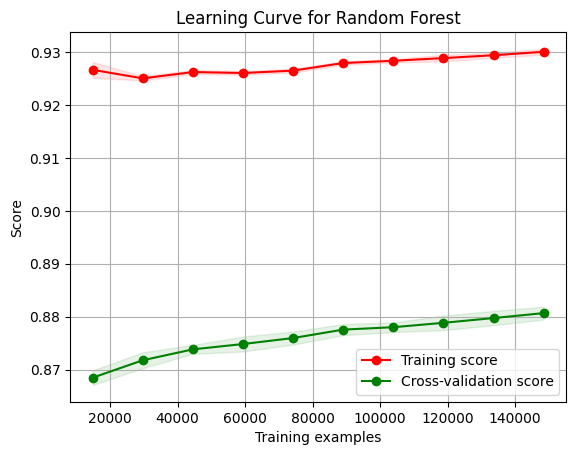

In [ ]:
#Random Forest 
#Learning Curve 
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

#Define the model
best_rf_classifier = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

#Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_classifier, X_train_tfidf, y_train_tfidf, cv=5, 
    scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

#Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

#Plot the learning curve
plt.figure()
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

#Plot the mean scores with standard deviation as error bars
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()


### Decision Tree

In [18]:
# Get the best estimator
best_dt_dep = grid_search_dt.best_estimator_

# Predict on the test data
y_pred = best_dt_dep.predict(X_test_bow)

# Print the classification report
print(classification_report(y_test_bow, y_pred))

              precision    recall  f1-score   support

  depression       0.89      0.85      0.87     23402
   teenagers       0.85      0.90      0.87     22997

    accuracy                           0.87     46399
   macro avg       0.87      0.87      0.87     46399
weighted avg       0.87      0.87      0.87     46399



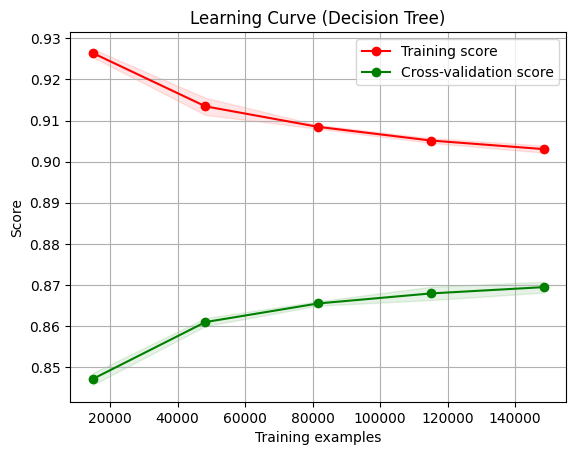

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier

# Define the function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Initialize the best Decision Tree classifier
best_dt_classifier = DecisionTreeClassifier(
    criterion='gini',
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=42
)

# Plot the learning curve
plot_learning_curve(best_dt_classifier, "Learning Curve (Decision Tree)", X_train_bow, y_train_bow, cv=5, n_jobs=-1)

# Show the plot
plt.show()

### SVM

In [ ]:
#Best Parameters
# Define the parameter grid for the SVM
param_grid_svm = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

# Initialize the SVM classifier
svm = SVC()

# Initialize GridSearchCV with the SVM and the parameter grid
grid_search_svm = GridSearchCV(svm, param_grid_svm, refit=True, 
                               verbose=3, cv=5, n_jobs=-1,return_train_score=True)

# Fit the grid search to the training data
grid_search_svm.fit(X_train_tfidf, y_train_tfidf)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best score: {grid_search_svm.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 2/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.923, test=0.916) total time=206.5min
[CV 3/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.923, test=0.916) total time=207.1min
[CV 5/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.923, test=0.918) total time=207.3min
[CV 1/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.922, test=0.918) total time=207.2min
[CV 4/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.922, test=0.918) total time=207.7min
[CV 1/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.918, test=0.908) total time=241.6min
[CV 2/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.918, test=0.906) total time=253.0min
[CV 3/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.918, test=0.907) total time=253.3min
[CV 2/5] END C=0.1, gamma=0.1, kernel=linear;, score=(train=0.923, test=0.916) total time=137.8min
[CV 1/5] END C=0.1, gamma=0.1, kernel=linear;, score=(train=0.922, test=0

In [ ]:
#After Tuning
# Use the best estimator to make predictions on the test set
best_svm = grid_search_svm.best_estimator_
y_pred = best_svm.predict(X_test_tfidf)

# Evaluate the performance
print(f"Accuracy: {accuracy_score(y_test_tfidf, y_pred)}")
print(f"Classification Report for SVM: \n{classification_report(y_test_tfidf, y_pred)}")


Accuracy: 0.9436625789348908
Classification Report for SVM: 
              precision    recall  f1-score   support

  depression       0.95      0.93      0.94     23402
   teenagers       0.93      0.95      0.94     22997

    accuracy                           0.94     46399
   macro avg       0.94      0.94      0.94     46399
weighted avg       0.94      0.94      0.94     46399



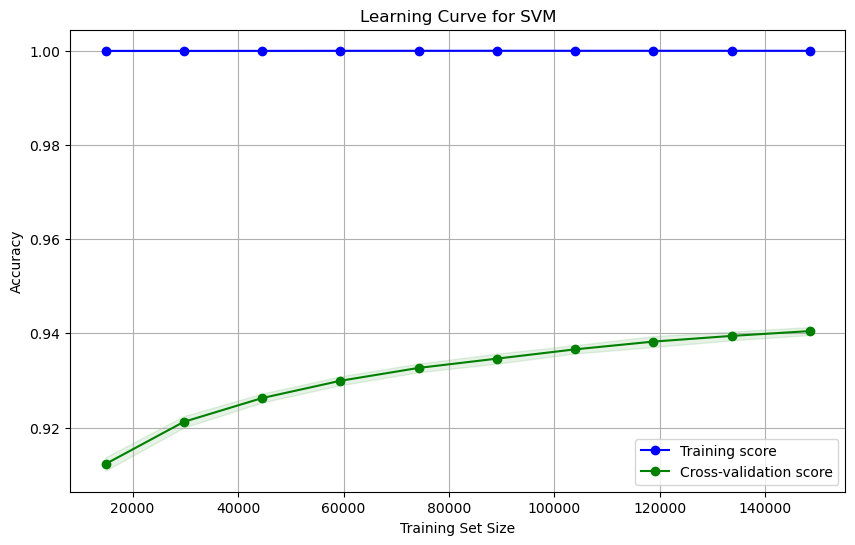

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, train_test_split

# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_svm, X=X_train_tfidf, y=y_train_tfidf, 
    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), 
    scoring='accuracy')

# Calculate the mean and standard deviation of the training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate the mean and standard deviation of the test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')

# Plot the standard deviation as a filled range
plt.fill_between(train_sizes, train_mean - train_std, train_mean 
                 + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean 
                 + test_std, color='green', alpha=0.1)

# Plot formatting
plt.title('Learning Curve for SVM')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

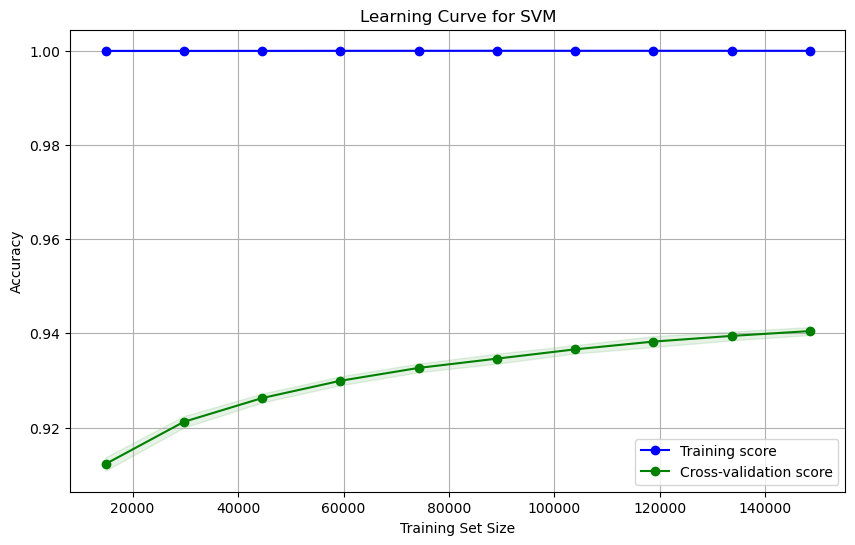

In [ ]:
svc_model = SVC(C=10, gamma=0.01, kernel='rbf')

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    estimator=svc_model, X=X_train_tfidf, y=y_train_tfidf, cv=5, n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')

# Plot the standard deviation as a filled range
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.1)

# Plot formatting
plt.title('Learning Curve for SVM')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### LR

In [22]:
# Get the best model
best_lr_classifier = grid_search_lr.best_estimator_

# Predict the labels for the test set using the best model
y_pred_tfidf_lr = best_lr_classifier.predict(X_test_tfidf)

# Evaluate the best model
print("Accuracy:", accuracy_score(y_test_tfidf, y_pred_tfidf_lr))
print("Classification Report:\n", classification_report(y_test_tfidf, y_pred_tfidf_lr))

Accuracy: 0.9322399189637708
Classification Report:
               precision    recall  f1-score   support

  depression       0.95      0.92      0.93     23402
   teenagers       0.92      0.95      0.93     22997

    accuracy                           0.93     46399
   macro avg       0.93      0.93      0.93     46399
weighted avg       0.93      0.93      0.93     46399



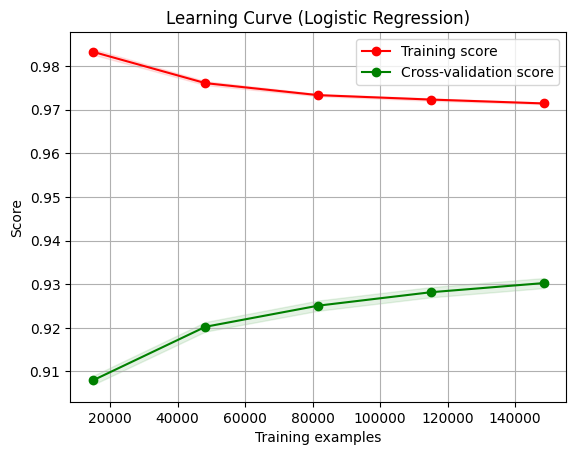

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

#Define the function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Initialize the best Logistic Regression classifier
best_lr_classifier = LogisticRegression(
    C=10,
    penalty='l2',
    solver='saga',
    random_state=42
)

#Plot the learning curve
plot_learning_curve(best_lr_classifier, "Learning Curve (Logistic Regression)", X_train_tfidf, y_train_tfidf, cv=5, n_jobs=-1)

#Show the plot
plt.show()

### KNN

In [ ]:
#After Tuning
best_knn_classifier = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='cosine'
)

# Train the KNN classifier
best_knn_classifier.fit(X_train_vector, y_train_vector)

# Predict the labels for the test set
y_pred_vector_knn = best_knn_classifier.predict(X_test_vector)

# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test_vector, y_pred_vector_knn))
print("Classification Report:\n", classification_report(y_test_vector, y_pred_vector_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test_vector, y_pred_vector_knn))

Test Accuracy: 0.870859285760469
Classification Report:
               precision    recall  f1-score   support

  depression       0.81      0.97      0.88     23402
   teenagers       0.97      0.77      0.85     22997

    accuracy                           0.87     46399
   macro avg       0.89      0.87      0.87     46399
weighted avg       0.89      0.87      0.87     46399

Confusion Matrix:
 [[22793   609]
 [ 5383 17614]]


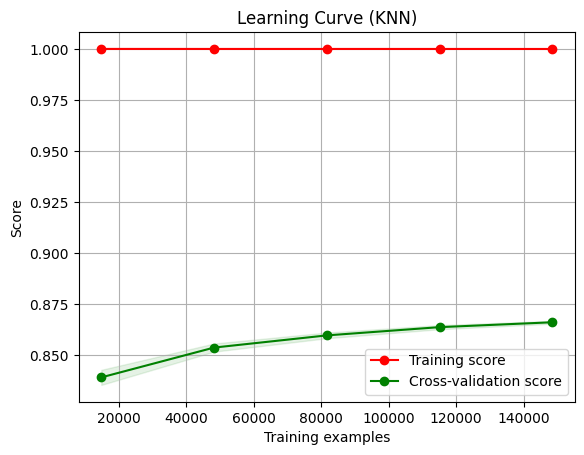

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier

#Define the function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Initialize the best KNN classifier
best_knn_classifier = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='cosine'
)

#Plot the learning curve
plot_learning_curve(best_knn_classifier, "Learning Curve (KNN)", X_train_vector, y_train_vector, cv=5, n_jobs=1)

#Show the plot
plt.show()

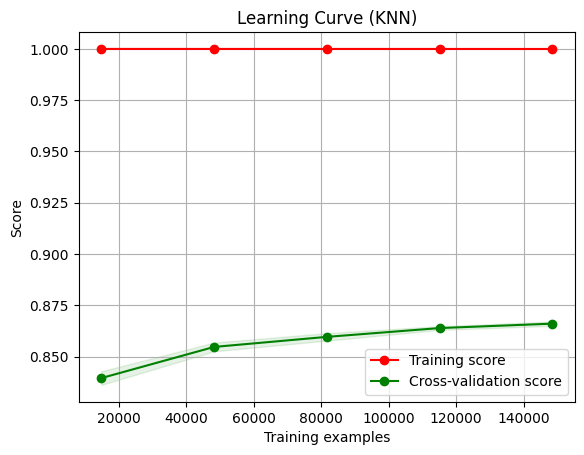

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier

#Define the function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Initialize the best KNN classifier
best_knn_classifier = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance',
    metric='cosine'
)

#Plot the learning curve
plot_learning_curve(best_knn_classifier, "Learning Curve (KNN)", X_train_vector, y_train_vector, cv=5, n_jobs=1)

#Show the plot
plt.show()

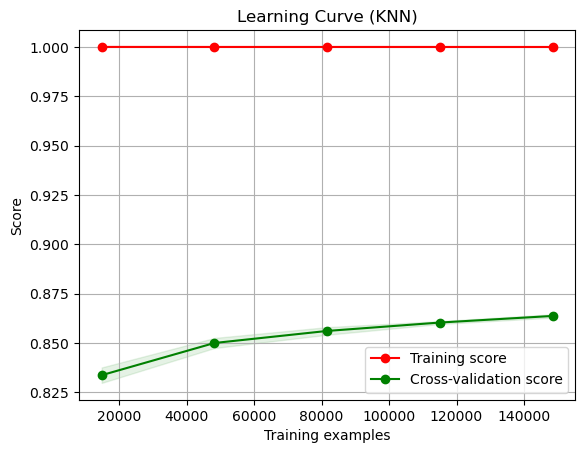

In [ ]:
# Test Learning Curve 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier

#Define the function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Initialize the best KNN classifier
best_knn_classifier = KNeighborsClassifier(
    n_neighbors=9,
    weights='distance',
    metric='cosine'
)

#Plot the learning curve
plot_learning_curve(best_knn_classifier, "Learning Curve (KNN)", X_train_vector, y_train_vector, cv=5, n_jobs=1)

#Show the plot
plt.show()

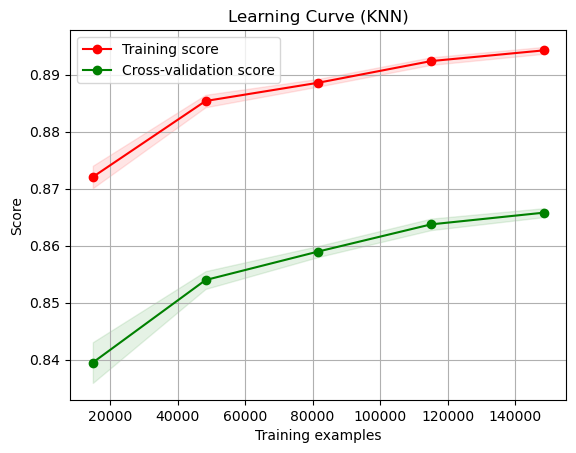

In [ ]:
# Test Learning Curve 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier

#Define the function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Initialize the best KNN classifier
best_knn_classifier = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    metric='cosine'
)

#Plot the learning curve
plot_learning_curve(best_knn_classifier, "Learning Curve (KNN)", X_train_vector, y_train_vector, cv=5, n_jobs=1)

#Show the plot
plt.show()

In [ ]:
# Initialize the KNeighborsClassifier with the specified hyperparameters
best_knn_classifier = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    metric='cosine'
)

# Fit the model on the training data
best_knn_classifier.fit(X_train_vector, y_train_vector)

# Make predictions on the test set
y_pred_knn = best_knn_classifier.predict(X_test_vector)

# Evaluate the model
accuracy = accuracy_score(y_test_vector, y_pred_knn)
report = classification_report(y_test_vector, y_pred_knn)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8691997672363628
Classification Report:
              precision    recall  f1-score   support

  depression       0.81      0.97      0.88     23402
   teenagers       0.97      0.76      0.85     22997

    accuracy                           0.87     46399
   macro avg       0.89      0.87      0.87     46399
weighted avg       0.89      0.87      0.87     46399



## Sentiment Prediction

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import ComplementNB

#Best Parameter (Grid Search)
# Define the parameter grid for the Multinomial Naive Bayes classifier
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]  # Alpha parameter for Laplace smoothing
}

# Initialize the Multinomial Naive Bayes classifier
nb_model = ComplementNB()

# Initialize the GridSearchCV object
grid_search_nb = GridSearchCV(estimator=nb_model, param_grid=param_grid_nb, cv=5, scoring='accuracy', return_train_score=True, verbose=3)

# Perform the grid search on the training data
grid_search_nb.fit(X_train_bow_sentiment, y_train_bow_sentiment)

# Get the best hyperparameters and the best model
best_params_nb = grid_search_nb.best_params_
best_model_nb = grid_search_nb.best_estimator_

# Make predictions on the test set using the best model
y_pred_nb = best_model_nb.predict(X_test_bow_sentiment)

# Evaluate the best model
accuracy = accuracy_score(y_test_bow_sentiment, y_pred_nb)
report = classification_report(y_test_bow_sentiment, y_pred_nb)

print("Best Hyperparameters:", best_params_nb)
print("Best Model - Accuracy:", accuracy)
print("Best Model - Classification Report:\n", report)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....alpha=0.1;, score=(train=0.784, test=0.673) total time=   0.8s
[CV 2/5] END .....alpha=0.1;, score=(train=0.782, test=0.671) total time=   0.7s
[CV 3/5] END .....alpha=0.1;, score=(train=0.785, test=0.669) total time=   0.8s
[CV 4/5] END .....alpha=0.1;, score=(train=0.782, test=0.677) total time=   0.7s
[CV 5/5] END .....alpha=0.1;, score=(train=0.782, test=0.675) total time=   0.6s
[CV 1/5] END .....alpha=0.5;, score=(train=0.760, test=0.679) total time=   0.6s
[CV 2/5] END .....alpha=0.5;, score=(train=0.758, test=0.678) total time=   0.7s
[CV 3/5] END .....alpha=0.5;, score=(train=0.760, test=0.675) total time=   0.9s
[CV 4/5] END .....alpha=0.5;, score=(train=0.758, test=0.683) total time=   0.9s
[CV 5/5] END .....alpha=0.5;, score=(train=0.758, test=0.679) total time=   0.7s
[CV 1/5] END .....alpha=1.0;, score=(train=0.745, test=0.683) total time=   0.8s
[CV 2/5] END .....alpha=1.0;, score=(train=0.744,

Final Training size: 25193
Final Training score: 0.7552
Final Cross-validation score: 0.6370


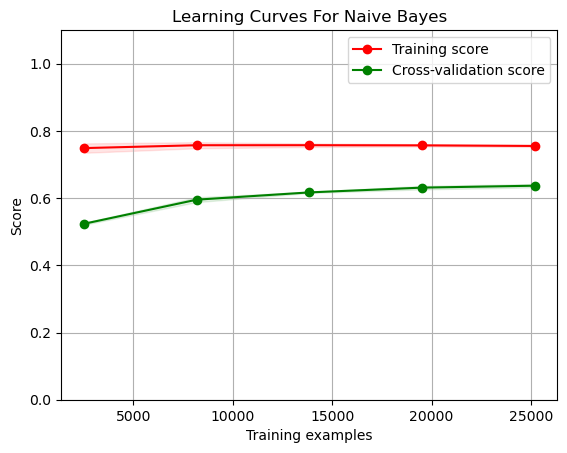

In [ ]:
#Cross-Validation
# Define the function to plot learning curves
def plot_learning_curve(estimator, X, y, title="Learning Curves For Naive Bayes", cv=None, n_jobs=None):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    # Calculate mean and standard deviation for train and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    final_train_size = train_sizes[-1]
    final_train_score = train_scores_mean[-1]
    final_test_score = test_scores_mean[-1]

    print(f"Final Training size: {final_train_size}")
    print(f"Final Training score: {final_train_score:.4f}")
    print(f"Final Cross-validation score: {final_test_score:.4f}")


    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0, 1.1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plot learning curves for the best model
plot_learning_curve(best_model_nb, X_train_bow_sentiment_down, y_train_bow_sentiment_down, cv=5)


Final Training size: 25193
Final Training score: 0.7234
Final Cross-validation score: 0.6324


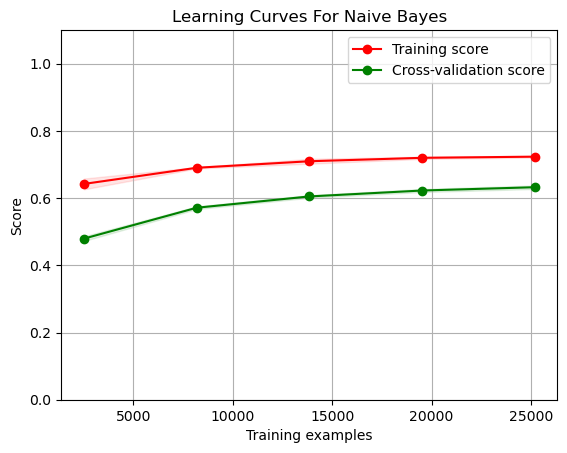

In [ ]:
test_model_nb_params = ComplementNB(alpha=2.0)

def plot_learning_curve(estimator, X, y, title="Learning Curves For Naive Bayes", cv=None, n_jobs=None):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    # Calculate mean and standard deviation for train and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Print final training and cross-validation scores
    final_train_size = train_sizes[-1]
    final_train_score = train_scores_mean[-1]
    final_test_score = test_scores_mean[-1]

    print(f"Final Training size: {final_train_size}")
    print(f"Final Training score: {final_train_score:.4f}")
    print(f"Final Cross-validation score: {final_test_score:.4f}")

    # Plot learning curves
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0, 1.1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Example usage with your best model
plot_learning_curve(test_model_nb_params, X_train_bow_sentiment_down, y_train_bow_sentiment_down, cv=5)


In [ ]:
from sklearn.naive_bayes import ComplementNB

nb_model = ComplementNB(alpha=2.0)

# Fit the model on the training data
nb_model.fit(X_train_bow_sentiment_down, y_train_bow_sentiment_down)

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test_bow_sentiment_down)

# Evaluate the model
accuracy = accuracy_score(y_test_bow_sentiment_down, y_pred_nb)
report = classification_report(y_test_bow_sentiment_down, y_pred_nb)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.6366522733045467
Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.78      0.68      2620
     Neutral       0.73      0.67      0.69      2694
    Positive       0.59      0.46      0.52      2560

    accuracy                           0.64      7874
   macro avg       0.64      0.64      0.63      7874
weighted avg       0.64      0.64      0.63      7874



### Decision Tree

In [ ]:
#Best Parameter (Grid Search)
#Define the parameter grid for the Decision Tree classifier
param_grid_dt_sent = {
    'criterion': ['gini', 'entropy'],      # Criterion for splitting
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 5]      # Minimum number of samples required to be at a leaf node
}

#Initialize the Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

#Initialize the GridSearchCV object
grid_search_dt_sent = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt_sent, cv=5, scoring='accuracy', n_jobs=1, verbose=3, return_train_score=True)

#Perform the grid search on the training data
grid_search_dt_sent.fit(X_train_bow_sentiment_down, y_train_bow_sentiment_down)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.705) total time=  21.4s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.721) total time=  22.2s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.713) total time=  20.7s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.716) total time=  21.8s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.720) total time=  20.9s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=(train=0.983, test=0.712) total time=  19.5s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=(train=0.983, tes

NameError: name 'best_model_dt_sent' is not defined

In [ ]:
#Get the best hyperparameters and the best model
best_params_dt_sent = grid_search_dt_sent.best_params_
best_model_dt_sent = grid_search_dt_sent.best_estimator_

#Make predictions on the test set using the best model
y_pred_dt_sent = best_model_dt_sent.predict(X_test_bow_sentiment_down)

#Evaluate the best model
accuracy_dt_sent = accuracy_score(y_test_bow_sentiment_down, y_pred_dt_sent)
report_dt_sent = classification_report(y_test_bow_sentiment_down, y_pred_dt_sent)

print("Best Hyperparameters for Decision Tree (Sentiment):", best_params_dt_sent)
print("Best Decision Tree Model (Sentiment) - Accuracy:", accuracy_dt_sent)
print("Best Decision Tree Model (Sentiment) - Classification Report:\n", report_dt_sent)

Best Hyperparameters for Decision Tree (Sentiment): {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Decision Tree Model (Sentiment) - Accuracy: 0.7282194564389128
Best Decision Tree Model (Sentiment) - Classification Report:
               precision    recall  f1-score   support

    Negative       0.65      0.64      0.64      2620
     Neutral       0.90      0.90      0.90      2694
    Positive       0.63      0.64      0.64      2560

    accuracy                           0.73      7874
   macro avg       0.73      0.73      0.73      7874
weighted avg       0.73      0.73      0.73      7874



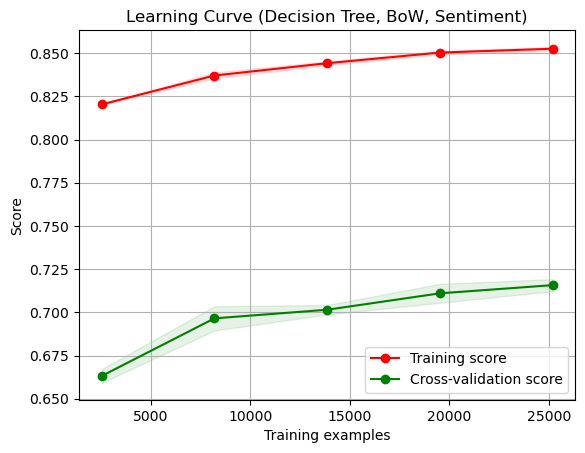

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

best_dt_classifier_sent = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=42
)

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(best_dt_classifier_sent, 
                    "Learning Curve (Decision Tree, BoW, Sentiment)", 
                    X_train_bow_sentiment_down, 
                    y_train_bow_sentiment_down, 
                    cv=5, 
                    n_jobs=1)
plt.show()

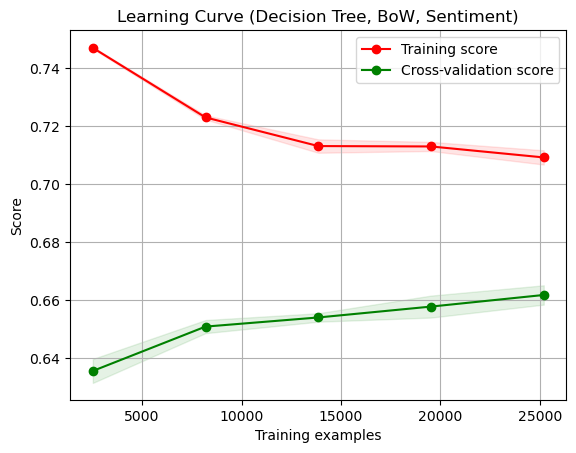

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

best_dt_classifier_sent = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=42
)

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(best_dt_classifier_sent, 
                    "Learning Curve (Decision Tree, BoW, Sentiment)", 
                    X_train_bow_sentiment_down, 
                    y_train_bow_sentiment_down, 
                    cv=5, 
                    n_jobs=1)
plt.show()

In [ ]:
# Initialize the classifier with the specified parameters
best_dt_classifier_sent = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=42
)

# Train the classifier
best_dt_classifier_sent.fit(X_train_bow_sentiment_down, y_train_bow_sentiment_down)

# Predict the labels for the test set
y_pred = best_dt_classifier_sent.predict(X_test_bow_sentiment_down)

# Generate the classification report
report = classification_report(y_test_bow_sentiment_down, y_pred)
print(report)

              precision    recall  f1-score   support

    Negative       0.66      0.51      0.58      2620
     Neutral       0.71      0.91      0.80      2694
    Positive       0.60      0.55      0.58      2560

    accuracy                           0.66      7874
   macro avg       0.66      0.66      0.65      7874
weighted avg       0.66      0.66      0.65      7874



### RNN

Epoch 1/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3629s 4s/step - accuracy: 0.6670 - loss: 0.7181 - val_accuracy: 0.8122 - val_loss: 0.4704
Epoch 2/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3506s 4s/step - accuracy: 0.8539 - loss: 0.3741 - val_accuracy: 0.8146 - val_loss: 0.4638
Epoch 3/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3432s 3s/step - accuracy: 0.8961 - loss: 0.2880 - val_accuracy: 0.8067 - val_loss: 0.4926
Epoch 4/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3273s 3s/step - accuracy: 0.9233 - loss: 0.2167 - val_accuracy: 0.8007 - val_loss: 0.5444
Epoch 5/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3254s 3s/step - accuracy: 0.9450 - loss: 0.1635 - val_accuracy: 0.7949 - val_loss: 0.6002
Epoch 6/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3257s 3s/step - accuracy: 0.9596 - loss: 0.1208 - val_accuracy: 0.7945 - val_loss: 0.6353
Epoch 7/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3243s 3s/step - accuracy: 0.9698 - loss: 0.0932 - val_accuracy: 0.7899 - val_loss: 0.8431
Epoch 8/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3254s 3s/step - accuracy: 0.9794 - loss: 0.0692 - 

AttributeError: 'KerasClassifierCustom' object has no attribute 'history'

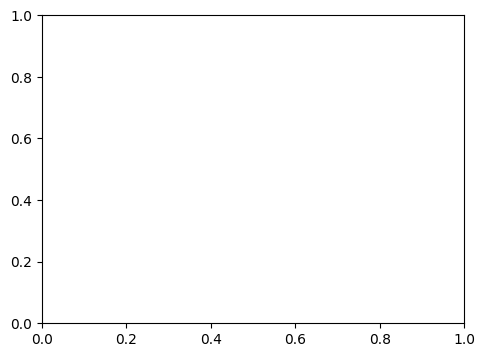

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# After Tuning
best_params_rnn = grid_result_rnn.best_params_

# Re-train the model using the best hyperparameters on the entire training data
best_model_rnn = KerasClassifierCustom(
    build_fn=create_rnn_model,
    vocab_size=vocab_size,
    num_classes=num_classes,
    epochs=best_params_rnn['epochs'],
    batch_size=best_params_rnn['batch_size'],
    lstm_units=best_params_rnn['lstm_units']
)

# Fit the model on the entire training data with validation data
history = best_model_rnn.fit(X_train_pad, y_train_cat, validation_data=(
    X_test_pad, y_test_cat))

# Predict the labels for the test data
y_pred_prob = best_model_rnn.predict(X_test_pad)
y_pred = y_pred_prob.argmax(axis=1)

# Convert one-hot encoded y_test_cat to class labels
y_true = y_test_cat.argmax(axis=1)

# Generate classification report
print("Classification Report for RNN:")
report = classification_report(y_true, y_pred)
print(report)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Epoch 1/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3321s 3s/step - accuracy: 0.6619 - loss: 0.7284 - val_accuracy: 0.8110 - val_loss: 0.4812
Epoch 2/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3234s 3s/step - accuracy: 0.8513 - loss: 0.3916 - val_accuracy: 0.8063 - val_loss: 0.4962
Epoch 3/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3295s 3s/step - accuracy: 0.8976 - loss: 0.2931 - val_accuracy: 0.8137 - val_loss: 0.5026
Epoch 4/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3142s 3s/step - accuracy: 0.9203 - loss: 0.2256 - val_accuracy: 0.8082 - val_loss: 0.5354
Epoch 5/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3177s 3s/step - accuracy: 0.9327 - loss: 0.1943 - val_accuracy: 0.7973 - val_loss: 0.6010
Epoch 6/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3251s 3s/step - accuracy: 0.9523 - loss: 0.1427 - val_accuracy: 0.7917 - val_loss: 0.6672
Epoch 7/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3219s 3s/step - accuracy: 0.9674 - loss: 0.1029 - val_accuracy: 0.7884 - val_loss: 0.7497
Epoch 8/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 3222s 3s/step - accuracy: 0.9734 - loss: 0.0836 - 

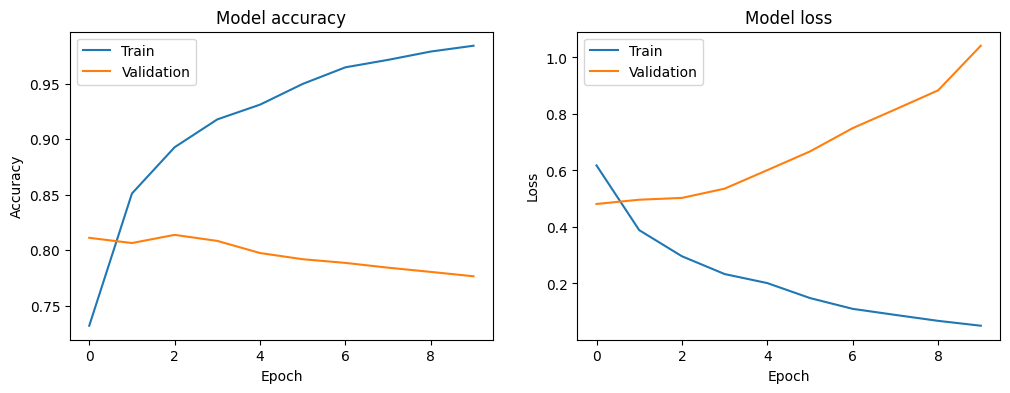

In [ ]:
best_params_rnn = {
    'batch_size': 32,
    'epochs': 10,
    'lstm_units': 64
}

# Re-train the model using the best hyperparameters on the entire training data
best_model_rnn = KerasClassifierCustom(
    build_fn=create_rnn_model,
    vocab_size=vocab_size,
    num_classes=num_classes,
    epochs=best_params_rnn['epochs'],
    batch_size=best_params_rnn['batch_size'],
    lstm_units=best_params_rnn['lstm_units']
)

class KerasClassifierCustom:
    def __init__(self, build_fn, vocab_size, num_classes, epochs, batch_size, lstm_units):
        self.build_fn = build_fn
        self.vocab_size = vocab_size
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_units = lstm_units
        self.history = None
        self.model = None

    def fit(self, X, y, validation_data=None):
        self.model = self.build_fn(vocab_size=self.vocab_size, num_classes=self.num_classes, lstm_units=self.lstm_units)
        self.history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_data=validation_data)
        return self.history  # Return the History object

    def predict(self, X):
        return self.model.predict(X)

# Then you can use the KerasClassifierCustom and access the history
best_model_rnn = KerasClassifierCustom(
    build_fn=create_rnn_model,
    vocab_size=vocab_size,
    num_classes=num_classes,
    epochs=best_params_rnn['epochs'],
    batch_size=best_params_rnn['batch_size'],
    lstm_units=best_params_rnn['lstm_units']
)

# Fit the model on the training data with validation data
history = best_model_rnn.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Epoch 1/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 11126s 11s/step - accuracy: 0.5942 - loss: 1.2391 - val_accuracy: 0.6260 - val_loss: 0.7755
Epoch 2/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 10631s 11s/step - accuracy: 0.5545 - loss: 0.8709 - val_accuracy: 0.6727 - val_loss: 0.6647
Epoch 3/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 10142s 10s/step - accuracy: 0.6846 - loss: 0.6314 - val_accuracy: 0.6618 - val_loss: 0.6916
Epoch 4/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 10161s 10s/step - accuracy: 0.7020 - loss: 0.6070 - val_accuracy: 0.6485 - val_loss: 0.7059
Epoch 5/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 10489s 11s/step - accuracy: 0.7242 - loss: 0.5869 - val_accuracy: 0.6849 - val_loss: 0.6738
Epoch 6/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 10137s 10s/step - accuracy: 0.7441 - loss: 0.5717 - val_accuracy: 0.6849 - val_loss: 0.6900
Epoch 7/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 9059s 9s/step - accuracy: 0.7394 - loss: 0.6191 - val_accuracy: 0.6758 - val_loss: 0.7196
Epoch 8/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 8974s 9s/step - accuracy: 0.7437 - los

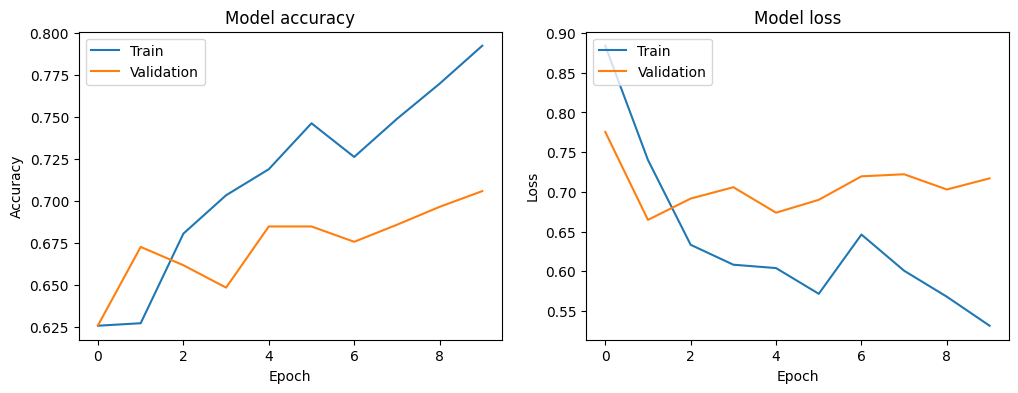

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

vocab_size = len(tokenizer.word_index) + 1

def create_rnn_model(vocab_size, num_classes, lstm_units=32, dropout_rate=0.3, l2_lambda=0.01):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100))
    model.add(LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_lambda)))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Updated KerasClassifierCustom with new parameters
class KerasClassifierCustom:
    def __init__(self, build_fn, vocab_size, num_classes, epochs, batch_size, lstm_units, dropout_rate, l2_lambda):
        self.build_fn = build_fn
        self.vocab_size = vocab_size
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.history = None
        self.model = None

    def fit(self, X, y, validation_data=None):
        self.model = self.build_fn(
            vocab_size=self.vocab_size,
            num_classes=self.num_classes,
            lstm_units=self.lstm_units,
            dropout_rate=self.dropout_rate,
            l2_lambda=self.l2_lambda
        )
        self.history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_data=validation_data)
        return self.history  # Return the History object

    def predict(self, X):
        return self.model.predict(X)
    
# Define the best model parameters manually
best_params_rnn = {
    'batch_size': 32,
    'epochs': 10,
    'lstm_units': 64
}

# Define the best model parameters including dropout_rate and l2_lambda
best_model_rnn = KerasClassifierCustom(
    build_fn=create_rnn_model,
    vocab_size=vocab_size,
    num_classes=num_classes,
    epochs=best_params_rnn['epochs'],
    batch_size=best_params_rnn['batch_size'],
    lstm_units=best_params_rnn['lstm_units'],
    dropout_rate=0.3,
    l2_lambda=0.01
)

# Retrain the model with the new configuration
history = best_model_rnn.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
vocab_size = len(tokenizer.word_index) + 1

def create_rnn_model(vocab_size, num_classes, lstm_units=32, dropout_rate=0.3, l2_lambda=0.01):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100))
    model.add(LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_lambda)))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Updated KerasClassifierCustom with new parameters
class KerasClassifierCustom:
    def __init__(self, build_fn, vocab_size, num_classes, epochs, batch_size, lstm_units, dropout_rate, l2_lambda):
        self.build_fn = build_fn
        self.vocab_size = vocab_size
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.history = None
        self.model = None

    def fit(self, X, y, validation_data=None):
        self.model = self.build_fn(
            vocab_size=self.vocab_size,
            num_classes=self.num_classes,
            lstm_units=self.lstm_units,
            dropout_rate=self.dropout_rate,
            l2_lambda=self.l2_lambda
        )
        self.history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_data=validation_data)
        return self.history  # Return the History object

    def predict(self, X):
        return self.model.predict(X)
    
# Define the best model parameters manually
best_params_rnn = {
    'batch_size': 32,
    'epochs': 10,
    'lstm_units': 64
}

# Define the best model parameters including dropout_rate and l2_lambda
best_model_rnn = KerasClassifierCustom(
    build_fn=create_rnn_model,
    vocab_size=vocab_size,
    num_classes=num_classes,
    epochs=best_params_rnn['epochs'],
    batch_size=best_params_rnn['batch_size'],
    lstm_units=best_params_rnn['lstm_units'],
    dropout_rate=0.3,
    l2_lambda=0.01
)

history = best_model_rnn.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat))

# Make predictions on the test set
y_pred_prob = best_model_rnn.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Convert y_test_cat from one-hot encoding to class labels
y_test = np.argmax(y_test_cat, axis=1)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report)

Epoch 1/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 15653s 16s/step - accuracy: 0.5879 - loss: 1.2469 - val_accuracy: 0.6422 - val_loss: 0.7154
Epoch 2/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 7460s 8s/step - accuracy: 0.6600 - loss: 0.6713 - val_accuracy: 0.6778 - val_loss: 0.6693
Epoch 3/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 7928s 8s/step - accuracy: 0.6984 - loss: 0.6193 - val_accuracy: 0.6965 - val_loss: 0.6689
Epoch 4/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 7839s 8s/step - accuracy: 0.7234 - loss: 0.5858 - val_accuracy: 0.7120 - val_loss: 0.6702
Epoch 5/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 10030s 10s/step - accuracy: 0.7528 - loss: 0.5794 - val_accuracy: 0.7094 - val_loss: 0.6739
Epoch 6/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 8938s 9s/step - accuracy: 0.7723 - loss: 0.5459 - val_accuracy: 0.7054 - val_loss: 0.6947
Epoch 7/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 10241s 10s/step - accuracy: 0.8028 - loss: 0.5094 - val_accuracy: 0.7597 - val_loss: 0.6350
Epoch 8/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 9508s 10s/step - accuracy: 0.8066 - loss: 0.

# Hybrid Model

In [ ]:
# Train the RNN model
best_model_rnn = KerasClassifierCustom(
    build_fn=create_rnn_model,
    vocab_size=vocab_size,
    num_classes=num_classes,
    epochs=best_params_rnn['epochs'],
    batch_size=best_params_rnn['batch_size'],
    lstm_units=best_params_rnn['lstm_units'],
    dropout_rate=0.3,
    l2_lambda=0.01
)

best_model_rnn.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat))

# Predict sentiment for the training data
sentiment_predictions_train_prob = best_model_rnn.predict(X_train_pad)
sentiment_predictions_train = np.argmax(sentiment_predictions_train_prob, axis=1)

# Predict sentiment for the test data
sentiment_predictions_test_prob = best_model_rnn.predict(X_test_pad)
sentiment_predictions_test = np.argmax(sentiment_predictions_test_prob, axis=1)

Epoch 1/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 6529s 7s/step - accuracy: 0.5832 - loss: 1.2417 - val_accuracy: 0.6660 - val_loss: 0.6881
Epoch 2/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 7272s 7s/step - accuracy: 0.6671 - loss: 0.6621 - val_accuracy: 0.6614 - val_loss: 0.6848
Epoch 3/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 5901s 6s/step - accuracy: 0.6825 - loss: 0.6288 - val_accuracy: 0.6866 - val_loss: 0.6587
Epoch 4/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 5510s 6s/step - accuracy: 0.7034 - loss: 0.6168 - val_accuracy: 0.6916 - val_loss: 0.6692
Epoch 5/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 5446s 6s/step - accuracy: 0.7381 - loss: 0.5816 - val_accuracy: 0.7096 - val_loss: 0.6615
Epoch 6/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 5465s 6s/step - accuracy: 0.7568 - loss: 0.5658 - val_accuracy: 0.7197 - val_loss: 0.6523
Epoch 7/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 5463s 6s/step - accuracy: 0.7764 - loss: 0.5385 - val_accuracy: 0.7201 - val_loss: 0.6635
Epoch 8/10
985/985 ━━━━━━━━━━━━━━━━━━━━ 5432s 6s/step - accuracy: 0.8143 - loss: 0.4962 - 

In [ ]:
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.sparse import hstack

# Convert sentiment predictions to feature arrays
sentiment_features_train = np.array(sentiment_predictions_train).reshape(-1, 1)
sentiment_features_test = np.array(sentiment_predictions_test).reshape(-1, 1)

# Convert sentiment features to sparse matrices
sentiment_features_train_sparse = csr_matrix(sentiment_features_train)
sentiment_features_test_sparse = csr_matrix(sentiment_features_test)

# Truncate X_train_tfidf and X_test_tfidf to match the sizes of 
# sentiment_features_train_sparse and sentiment_features_test_sparse
X_train_tfidf_truncated = X_train_tfidf[:sentiment_features_train_sparse.shape[0], :]
X_test_tfidf_truncated = X_test_tfidf[:sentiment_features_test_sparse.shape[0], :]

# Stack the truncated TF-IDF features with sentiment predictions
X_train_with_sentiment_sparse = hstack([X_train_tfidf_truncated, sentiment_features_train_sparse])
X_test_with_sentiment_sparse = hstack([X_test_tfidf_truncated, sentiment_features_test_sparse])

# Scale the feature matrices
scaler = StandardScaler(with_mean=False)
X_train_with_sentiment_scaled = scaler.fit_transform(X_train_with_sentiment_sparse)
X_test_with_sentiment_scaled = scaler.transform(X_test_with_sentiment_sparse)

# Initialize and train the Logistic Regression model
best_lr_classifier = LogisticRegression(
    C=10,
    penalty='l2',
    solver='saga',
    random_state=42,
    max_iter=10000
)

best_lr_classifier.fit(X_train_with_sentiment_scaled, 
                       y_train_tfidf[:sentiment_features_train_sparse.shape[0]])

# Predict depression status using the trained Logistic Regression model
depression_predictions = best_lr_classifier.predict(X_test_with_sentiment_scaled)

# Print classification report
print(classification_report(y_test_tfidf[:sentiment_features_test_sparse.shape[0]], 
                            depression_predictions))

              precision    recall  f1-score   support

  depression       0.90      0.88      0.89      3898
   teenagers       0.88      0.90      0.89      3976

    accuracy                           0.89      7874
   macro avg       0.89      0.89      0.89      7874
weighted avg       0.89      0.89      0.89      7874



# Save Pickle File 

In [25]:
import pickle
import os
import pandas as pd
import numpy as np
import gensim

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import learning_curve


filepath = "/Users/huiyee/Downloads/Study/Year3Sem1/FYP/new_df.csv"
new_df = pd.read_csv(filepath)

# # Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(new_df['joined_tokens'])

save_path = '/Users/huiyee/Downloads/Study/Year3Sem2/FYP_project/backend_copy'

os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, 'tfidf_matrix.pkl'), 'wb') as f:
    pickle.dump(vectorizer, f)

In [ ]:
# Assuming you have the following objects defined
hybrid_model_dict = {
    'tokenizer': tokenizer,
    'scaler': scaler,
    'classifier': best_lr_classifier
}

# Save the model_dict to a pickle file
with open('hybrid_model.pkl', 'wb') as file:
    pickle.dump(hybrid_model_dict, file)

# Save sentiment classifier (RNN model)
best_model_rnn.model.save('sentiment_classifier_rnn.h5')  # Save the Keras model in HDF5 format

print("Hybrid model saved successfully.")

Hybrid model saved successfully.
